# UCF50 Sports Dataset

**Subset: 5 Sports**

- Basketball
- PlayingPiano
- PullUps
- Skiing
- WalkingWithDog

## Dependecies

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Functions

### Extract Frames

In [2]:
def extract_frames(video_path, frame_size=(112, 112), frame_num=16):
    try:
        video = cv2.VideoCapture(video_path)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            print(f"Error: No se encontraron frames en el video {video_path}")
            return None

        interval = total_frames // frame_num

        frames = []
        previous_frame = None

        for i in range(frame_num):
            frame_index = min(i * interval, total_frames - 1)
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = video.read()

            if ret:
                frame_resized = cv2.resize(frame, frame_size)
                frame_normalized = frame_resized / 255.0
                frames.append(frame_normalized)
                previous_frame = frame_normalized
            else:
                print(f"Error al leer el frame {frame_index} del video {video_path}. Usando el frame anterior.")
                if previous_frame is not None:
                    frames.append(previous_frame)
                else:
                    print(f"Error: No se pudo usar un frame anterior para {video_path} en el índice {frame_index}. Video posiblemente corrupto.")
                    video.release()
                    return None

        video.release()

        if len(frames) < frame_num:
            print(f"Advertencia: El video {video_path} tiene menos frames de los esperados. Usando los frames disponibles.")

        return np.array(frames)

    except Exception as e:
        print(f"Error al procesar el video {video_path}: {e}")
        return None

### Build Dataset

In [3]:
def build_dataset(path, frame_size=(32, 32), frame_num=16):

    # Remove .ipynb_checkpoints directory inside the function
    checkpoint_dir = os.path.join(path, ".ipynb_checkpoints")
    if os.path.exists(checkpoint_dir):
        try:
            shutil.rmtree(checkpoint_dir)
            print(f"Removed .ipynb_checkpoints directory from: {path}")
        except Exception as e:
            print(f"Error removing .ipynb_checkpoints directory: {e}")

    data = []
    labels = []
    categories = sorted(os.listdir(path))

    label_encoder = LabelEncoder()
    label_encoder.fit(categories)
    print("Categorías:", label_encoder.classes_)
    for category in categories:
        category_path = os.path.join(path, category)
        print(f"Procesando videos de la categoría {category}...")
        for video_name in os.listdir(category_path):
            if video_name.endswith(('.avi', '.mp4', '.mov')):
                video_path = os.path.join(category_path, video_name)
                frames = extract_frames(video_path, frame_size, frame_num)
                if frames is not None:
                    data.append(frames)
                    label_numeric = label_encoder.transform([category])[0]
                    labels.append(label_numeric)
                else:
                    print(f"Error: No se pudieron extraer frames del video {video_path}. Omitiendo.")

    return data, labels, label_encoder

### Build CNN Model

In [4]:
def build_cnn(frame_size):

    input_tensor = Input(shape=(None, frame_size[0], frame_size[1], 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(frame_size[0], frame_size[1], 3))
    base_model.trainable = False
    time_distributed_layer = TimeDistributed(base_model)(input_tensor)

    cnn_model = Model(inputs=input_tensor, outputs=time_distributed_layer)

    return cnn_model

### Build CNN LSTM Model

In [5]:
def build_cnn_lstm(frame_size, num_clases):

    cnn = build_cnn(frame_size)

    cnn_output_shape = cnn.output.shape
    reshape_dim = (cnn_output_shape[-2] * cnn_output_shape[-1])
    reshaped_output = Reshape((-1, reshape_dim))(cnn.output)
    lstm_layer = LSTM(64)(reshaped_output)
    dropout_layer = Dropout(0.5)(lstm_layer)
    output_layer = Dense(num_clases, activation='softmax')(dropout_layer)

    model = Model(inputs=cnn.input, outputs=output_layer)

    return model


### Train Model

In [6]:
def train_model(model, data, labels, frame_size, num_clases, epochs=10, batch_size=32):

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    loss, precision = model.evaluate(X_test, y_test, verbose=0)
    print(f"Pérdida en el conjunto de prueba: {loss}")
    print(f"Precisión en el conjunto de prueba: {precision}")

    model.save("model.keras")
    print("Modelo guardado.")

    return history

### Inference

In [7]:
def inference(model, video_path, label_encoder, frame_size=(32, 32), num_frames=16):

    try:
        frames = extract_frames(video_path, frame_size, num_frames)

        if frames is None:
            print(f"Error: No se pudieron extraer frames del video {video_path}")
            return None

        frames = np.expand_dims(frames, axis=0)

        probabilities = model.predict(frames)
        predicted_class_index = np.argmax(probabilities)
        predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

        return predicted_class

    except Exception as e:
        print(f"Error durante la inferencia: {e}")
        return None


### Sample Predictions

In [17]:
def sample_predictions(model, path, label_encoder, video_number=0, frame_size=(32, 32), num_frames=16):

    categories = sorted(os.listdir(path))

    for category in categories:
        category_path = os.path.join(path, category)
        videos = sorted(os.listdir(category_path))

        if videos:
            first_video = videos[0]
            video_path = os.path.join(category_path, first_video)

            prediction = inference(model, video_path, label_encoder, frame_size, num_frames) # Use inference function

            if prediction==category:
                print(f"Categoría: {category}")
                print(f"Video: {first_video}")
                print(f"Clase predicha: {prediction}")

                try:  # Try to display a frame
                    video_capture = cv2.VideoCapture(video_path)
                    ret, frame = video_capture.read()
                    video_capture.release()

                    if ret:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        plt.imshow(frame)
                        plt.title(f"Video: {first_video}")
                        plt.axis('off')
                        plt.show()
                    else:
                        print("No se pudo leer el primer frame del video para mostrar.")
                except Exception as e:
                    print(f"Error displaying frame: {e}")

            else:
                print(f"Error: No se pudieron extraer frames o realizar la inferencia para {video_path}")
        else:
            print(f"No se encontraron videos en la categoría: {category}")


In [28]:
def yt_sample_predictions(model, path, label_encoder, video_number=0, frame_size=(32, 32), num_frames=16):

      videos = sorted(os.listdir(path))

      if videos:
          for video in videos:
            video_path = os.path.join(path, video)

            prediction = inference(model, video_path, label_encoder, frame_size, num_frames) # Use inference function

            if prediction:
                print(f"Video: {video}")
                print(f"Clase predicha: {prediction}")

                try:  # Try to display a frame
                    video_capture = cv2.VideoCapture(video_path)
                    ret, frame = video_capture.read()
                    video_capture.release()

                    if ret:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        plt.imshow(frame)
                        plt.title(f"Video: {video}")
                        plt.axis('off')
                        plt.show()
                    else:
                        print("No se pudo leer el primer frame del video para mostrar.")
                except Exception as e:
                    print(f"Error displaying frame: {e}")

          else:
              print(f"Error: No se pudieron extraer frames o realizar la inferencia para {video_path}")
      else:
          print(f"No se encontraron videos")


## Testing

### Extract Frames

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
video_path = "/content/drive/MyDrive/RNN/Biking/v_Biking_g01_c01.avi"
frames_processed = extract_frames(video_path)

if frames_processed is not None:
    print("Frames extraídos y procesados correctamente.")
    print("Shape del array de frames:", frames_processed.shape)

else:
    print("Error al samplear los frames del vídeo.")

Frames extraídos y procesados correctamente.
Shape del array de frames: (16, 112, 112, 3)


### Build CNN Model

In [11]:
frame_size = (112, 112)
cnn = build_cnn(frame_size)

cnn.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 112, 112, │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 4, 4,     │    23,587,712 │
│ (TimeDistributed)               │ 2048)                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Build CNN LSTM Model

In [12]:
frame_size = (32, 32)
num_clases = 5
cnn_lstm_model = build_cnn_lstm(frame_size, num_clases)

cnn_lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, 32, 32,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 1, 1,     │    23,587,712 │
│ (TimeDistributed)               │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,128,965 (92.04 MB)

 Trainable params: 541,253 (2.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Execution

In [13]:
data_path = "/content/drive/MyDrive/RNN"
data, labels, label_encoder = build_dataset(data_path)

Categorías: ['Biking' 'Billiards' 'Drumming' 'PushUps' 'TennisSwing']
Procesando videos de la categoría Biking...
Procesando videos de la categoría Billiards...
Procesando videos de la categoría Drumming...
Procesando videos de la categoría PushUps...
Procesando videos de la categoría TennisSwing...


In [14]:
data = np.array(data)
labels = to_categorical(labels)

print("Shape de los datos:", data.shape)
print("Shape de las etiquetas:", labels.shape)

Shape de los datos: (729, 16, 32, 32, 3)
Shape de las etiquetas: (729, 5)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.2268 - loss: 1.7462 - val_accuracy: 0.2808 - val_loss: 1.5797
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.2241 - loss: 1.6506 - val_accuracy: 0.2740 - val_loss: 1.5873
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.2643 - loss: 1.6092 - val_accuracy: 0.5000 - val_loss: 1.5328
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.2714 - loss: 1.5964 - val_accuracy: 0.3151 - val_loss: 1.5284
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2207 - loss: 1.6342 - val_accuracy: 0.4795 - val_loss: 1.5037
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2932 - loss: 1.5628 - val_accuracy: 0.5137 - val_loss: 1.4714
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3638 - loss: 1.4879 - val_accuracy: 0.5342 - val_loss: 1.4427
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3307 - loss: 1.5160 - val_accuracy: 0.4863 - 

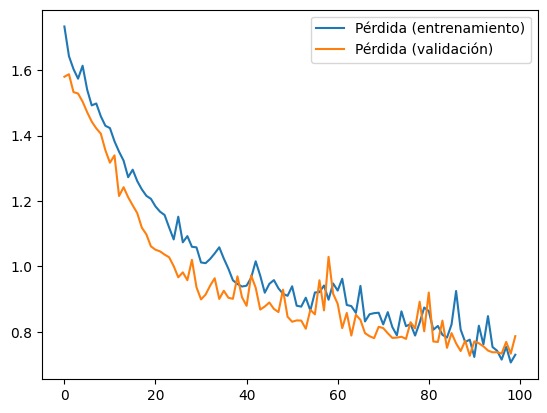

In [15]:
training_history = train_model(
    cnn_lstm_model, data, labels, frame_size, num_clases, epochs=100, batch_size=16
)

plt.plot(training_history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(training_history.history['val_loss'], label='Pérdida (validación)')
plt.legend()
plt.show()

## Sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
Error: No se pudieron extraer frames o realizar la inferencia para /content/drive/MyDrive/RNN/Biking/v_Biking_g01_c01.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Categoría: Billiards
Video: v_Billards_g01_c01.avi
Clase predicha: Billiards


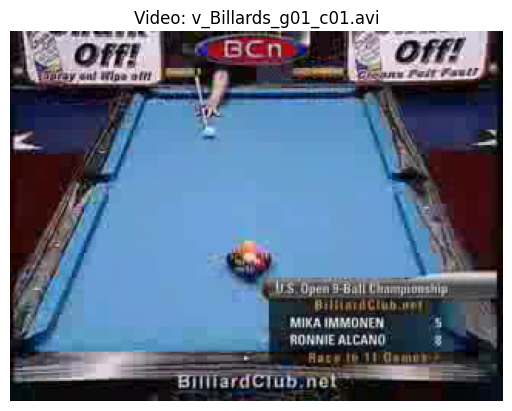

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
Categoría: Drumming
Video: v_Drumming_g01_c01.avi
Clase predicha: Drumming


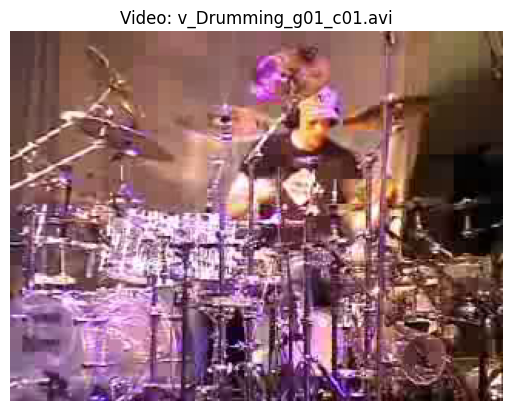

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Error: No se pudieron extraer frames o realizar la inferencia para /content/drive/MyDrive/RNN/PushUps/v_PushUps_g01_c01.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Error: No se pudieron extraer frames o realizar la inferencia para /content/drive/MyDrive/RNN/TennisSwing/v_TennisSwing_g01_c01.avi


In [22]:
path = "/content/drive/MyDrive/RNN"
loaded_model = tf.keras.models.load_model("model.keras")
sample_predictions(loaded_model, path, label_encoder)

## YouTube Videos

Error: No se encontraron frames en el video /content/drive/MyDrive/EDEM/YT/.ipynb_checkpoints
Error: No se pudieron extraer frames del video /content/drive/MyDrive/EDEM/YT/.ipynb_checkpoints
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step
Video: Grabación de pantalla 2025-04-19 123058.mp4
Clase predicha: TennisSwing


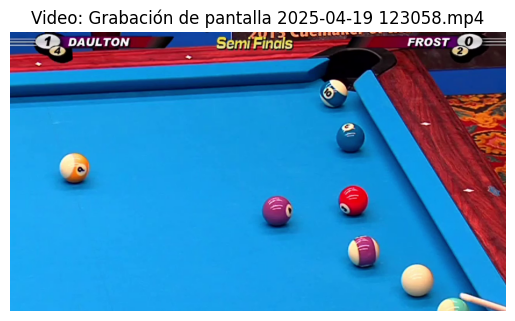

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Video: Grabación de pantalla 2025-04-19 123435.mp4
Clase predicha: Biking


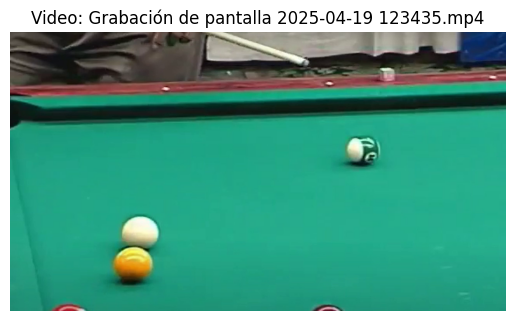

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Video: Grabación de pantalla 2025-04-20 120653.mp4
Clase predicha: Biking


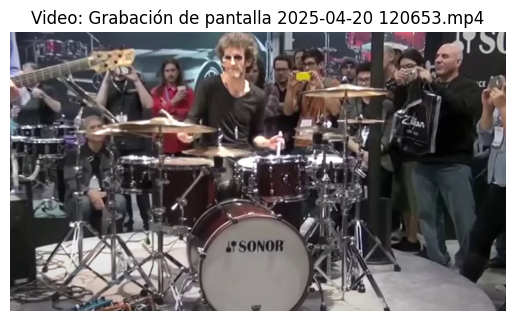

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Video: Grabación de pantalla 2025-04-20 120858.mp4
Clase predicha: PushUps


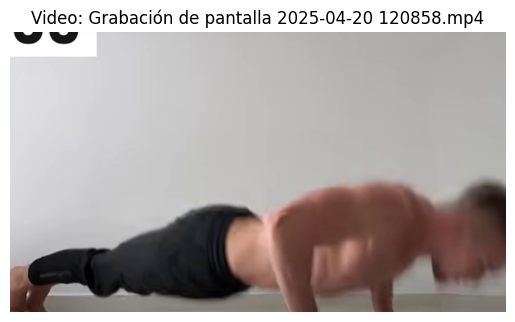

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
Video: Grabación de pantalla 2025-04-20 121046.mp4
Clase predicha: TennisSwing


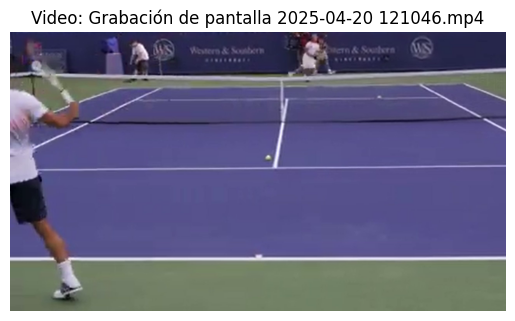

Error: No se pudieron extraer frames o realizar la inferencia para /content/drive/MyDrive/EDEM/YT/Grabación de pantalla 2025-04-20 121046.mp4


In [29]:
path = "/content/drive/MyDrive/EDEM/YT"
loaded_model = tf.keras.models.load_model("model.keras")
yt_sample_predictions(loaded_model, path, label_encoder)